<a href="https://colab.research.google.com/github/Koichi5/python_projects/blob/main/kaggle_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import os

In [ ]:
# Reading the training data from the csv file
train = pd.read_csv("/content/drive/MyDrive/Csv Folder/kaggle_titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Reading the testing data from the csv file
test = pd.read_csv("/content/drive/MyDrive/Csv Folder/kaggle_titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**We pre-emptively extract and then remove the target variable from the training set. This allows us to concatenate the training and testing sets and work with a single dataframe for data cleaning instead of having to separately clean both the training and testing sets. It also allows us to standardise both the training and test data together as we will see later.**

In [ ]:
# train をコピーしたデータを train1 に代入
train1 = train.copy()

# train1 の Survived の列を y_train へ代入
y_train = train1.Survived

# train1 のデータから Survived の列を削除
train1.drop(['Survived'], axis = 1, inplace = True)

In [ ]:
# 先ほど Survived の列を削除した train1 を test データと結合
# test データが下になるように結合
# 1309列　11行のデータが完成
comb = pd.concat([train1,test], axis = 0, ignore_index= True)
comb.shape

(1309, 11)

In [ ]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


# Null Value の処理

In [ ]:
# null のデータがいくつあるかを確認
comb.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
# null のデータが全体のデータの何%になるかを計算
# 「Cabin」のデータの77.46%と大多数が null であることがわかる
((comb.isnull().sum() / comb.isnull().count()) * 100).round(2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.09
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.08
Cabin          77.46
Embarked        0.15
dtype: float64

In [ ]:
# fillna() メソッドは 欠損値を他の値に置換（穴埋め）するためのメソッド。
# 今回は Cabin の欠損値を N/A として穴埋め
comb["Cabin"].fillna("N/A", inplace = True)
comb

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N/A,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N/A,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N/A,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,N/A,S
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,N/A,S
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,N/A,S


In [ ]:
# これで Cabin の null が 0% になったことがわかる
((comb.isnull().sum() / comb.isnull().count()) * 100).round(2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.09
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.08
Cabin           0.00
Embarked        0.15
dtype: float64

In [ ]:
# Embark も欠損値が２つあり、その割合は 0.15% である。
# ここでは最も乗客が乗船した港の町を代入することにする。
# mode() は最頻値を求めるメソッドである。

# ここで Embarked の最頻値が S であることがわかる
# comb['Embarked'].mode()[0]

# comb の欠損値に S を代入
comb['Embarked'].fillna((comb['Embarked'].mode()[0]), inplace = True)

In [ ]:
# Age には欠損値が263あり、その割合へ20.09%である。
# 名前についている敬称( Mr, Miss, Mrs など )からおおよその年齢を推定する！


#Defining a function to extract the honorific from a name:
# name という変数を引数にとり、 honorific の初期値は空の文字列
# 敬称が置かれているのは「Braund, Mr. Owen Harris」「Cumings, Mrs. John Bradley」のように
# 「,」の後、「.」の前であることを利用する
def extract_honorific(name):
    record = False
    honorific = ''
    for i, char in enumerate(name):
        if char == ',':
            record = True
        if char == '.':
            record = False
        if record == True:
            honorific += name[i + 2]
    return honorific[:-1]

#Finding the honorifics of all the passengers:
# honorifics には敬称のリストが代入されている。
honorifics = [extract_honorific(name) for name in comb.Name]

#Creating a new "Honorific" column:
# honoridics のリストを comb の４列目に挿入している
comb.insert(3, "Honorific", honorifics)
comb.head()

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",Mr.,male,22.0,1,0,A/5 21171,7.2500,N/A,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs.,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",Miss.,female,26.0,0,0,STON/O2. 3101282,7.9250,N/A,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs.,female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",Mr.,male,35.0,0,0,373450,8.0500,N/A,S


In [ ]:
# 先ほど追加した Honorific の列のそれぞれの数を算出
# Mr が最も多く、次にMiss, Mrs と続く
comb.Honorific.value_counts()

Mr.              757
Miss.            260
Mrs.             197
Master.           61
Rev.               8
Dr.                8
Col.               4
Mlle.              2
Major.             2
Ms.                2
Lady.              1
Sir.               1
Mme.               1
Don.               1
Capt.              1
the Countess.      1
Jonkheer.          1
Dona.              1
Name: Honorific, dtype: int64

In [ ]:
# 敬称ごとの年齢の中央値を計算
# comb をまず Honorific でグループ分け
# グループ分けしたものの Age の中央値を計算
# 敬称ごとの年齢の中央値を並び替え。 ascending = False にすることで昇順ではなく降順になる
# 一例として、年齢の平均値が　4.0 の「Master」 は少年ないし青年男性に用いられる敬称である
median_ages = pd.Series(comb.groupby(by = "Honorific")["Age"].median())
median_ages.sort_values(ascending = False)

Honorific
Capt.            70.0
Col.             54.5
Dr.              49.0
Sir.             49.0
Major.           48.5
Lady.            48.0
Rev.             41.5
Don.             40.0
Dona.            39.0
Jonkheer.        38.0
Mrs.             35.5
the Countess.    33.0
Mr.              29.0
Ms.              28.0
Mme.             24.0
Mlle.            24.0
Miss.            22.0
Master.           4.0
Name: Age, dtype: float64

In [ ]:
comb1 = pd.DataFrame(columns = comb.columns)
# この時点で comb1 は列の head のみで、データはない。

# Honorific でグループ分けした結果を honorigicGroup へ代入
honorificGroup = comb.groupby(by = "Honorific")

# for文を使って df_honorific の Age が null である場合にその敬称に応じた年齢の中央値を代入
for _, df_honorific in honorificGroup:
  df_honorific["Age"].fillna(df_honorific["Age"].median(),inplace = True)
  comb1 = pd.concat([comb1, df_honorific], axis = 0)

comb1

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,1,"Crosby, Capt. Edward Gifford",Capt.,male,70.0,1,1,WE/P 5735,71.0000,B22,S
647,648,1,"Simonius-Blumer, Col. Oberst Alfons",Col.,male,56.0,0,0,13213,35.5000,A26,C
694,695,1,"Weir, Col. John",Col.,male,60.0,0,0,113800,26.5500,N/A,S
1022,1023,1,"Gracie, Col. Archibald IV",Col.,male,53.0,0,0,113780,28.5000,C51,C
1093,1094,1,"Astor, Col. John Jacob",Col.,male,47.0,1,0,PC 17757,227.5250,C62 C64,C
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",Rev.,male,27.0,0,0,211536,13.0000,N/A,S
1040,1041,2,"Lahtinen, Rev. William",Rev.,male,30.0,1,1,250651,26.0000,N/A,S
1055,1056,2,"Peruschitz, Rev. Joseph Maria",Rev.,male,41.0,0,0,237393,13.0000,N/A,S
599,600,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",Sir.,male,49.0,1,0,PC 17485,56.9292,A20,C


In [ ]:
# これで comb1 のデータでは Age が null である割合は 0% になった。
((comb1.isnull().sum() / comb1.isnull().count()) * 100).round(2)

PassengerId    0.00
Pclass         0.00
Name           0.00
Honorific      0.00
Sex            0.00
Age            0.00
SibSp          0.00
Parch          0.00
Ticket         0.00
Fare           0.08
Cabin          0.00
Embarked       0.00
dtype: float64

In [ ]:
# 年齢の中央値
comb1["Age"].median()

29.0

In [ ]:
# 年齢の基本統計量
# 第三四部位数が 35.5 って若くない？
comb1["Age"].describe()

count    1309.000000
mean       29.432521
std        13.163767
min         0.170000
25%        22.000000
50%        29.000000
75%        35.500000
max        80.000000
Name: Age, dtype: float64

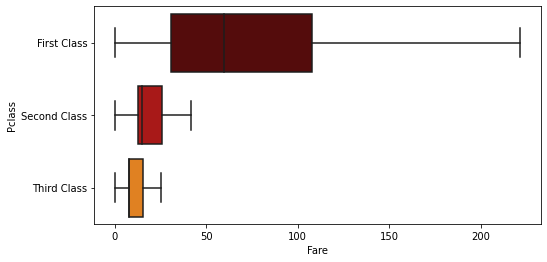

In [ ]:
from numpy.ma.core import correlate
# 乗客のクラス（Passenger Class = Pclass） と 料金の相関関係を比較
# Pclass は 1~3 まであり、 1 = 1st class 2 = 2nd class 3 = 3rd. class

# boxplot によって箱ひげ図を記述
# orient は箱ひげ図を垂直方向か水平方法のどちらへ展開するかを決定
plt.figure(figsize = (8,4))
sns.boxplot(y = comb1.Pclass, x = comb1.Fare, orient = "h", showfliers = False, palette = "gist_heat")
plt.yticks([0,1,2], ["First Class","Second Class","Third Class"])
plt.show()

As we can see, there is a clear (negative) correlation between the passenger class (Pclass) and the ticket fare (Fare). Therefore, to fill in the missing fare values, we use the median fares of their respective passenger class instead of using mean or median of the 'Fare' column.

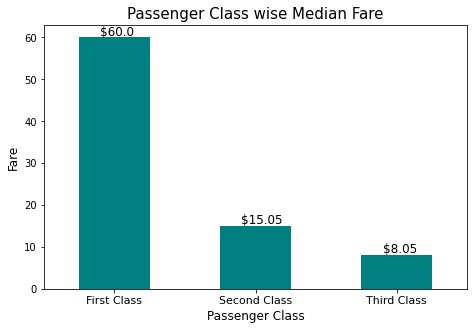

In [ ]:
#Checking the passenger-class-wise median fare:
# クラスごとの乗客の料金の中央値を計算
median_fares = pd.Series(comb1.groupby(by = 'Pclass')['Fare'].median())
plt.figure(figsize = (5,3))
median_fares.plot(kind = 'bar', color = 'teal')
plt.text(x = -0.1, y = median_fares.loc[1] + 0.5, s = "${}".format(median_fares.loc[1].round(2)), fontsize = 12)
plt.text(x = -0.1 + 1, y = median_fares.loc[2] + 0.5, s = "${}".format(median_fares.loc[2].round(2)), fontsize = 12)
plt.text(x = -0.1 + 2, y = median_fares.loc[3] + 0.5, s = "${}".format(median_fares.loc[3].round(2)), fontsize = 12)
plt.xlabel('Passenger Class', fontsize = 12)
plt.ylabel('Fare', fontsize = 12)
plt.title('Passenger Class wise Median Fare', fontsize = 15)
plt.xticks([0,1,2], ['First Class', 'Second Class', 'Third Class'], rotation = 'horizontal', fontsize = 11)
plt.tight_layout(pad = -5)
plt.show()

In [ ]:
# 乗客のクラスによってグループ分けをして、 Fare の欠損値を埋める

comb2 = pd.DataFrame(columns = comb1.columns)

pclassGroup = comb1.groupby(by = "Pclass")
for _, df_pclass in pclassGroup:
  df_pclass["Fare"].fillna(df_pclass["Fare"].median(), inplace = True)
  comb2 = pd.concat([comb2, df_pclass], axis = 0)

comb2

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,1,"Crosby, Capt. Edward Gifford",Capt.,male,70.0,1,1,WE/P 5735,71.000,B22,S
647,648,1,"Simonius-Blumer, Col. Oberst Alfons",Col.,male,56.0,0,0,13213,35.500,A26,C
694,695,1,"Weir, Col. John",Col.,male,60.0,0,0,113800,26.550,N/A,S
1022,1023,1,"Gracie, Col. Archibald IV",Col.,male,53.0,0,0,113780,28.500,C51,C
1093,1094,1,"Astor, Col. John Jacob",Col.,male,47.0,1,0,PC 17757,227.525,C62 C64,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1250,1251,3,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",Mrs.,female,30.0,1,0,349910,15.550,N/A,S
1256,1257,3,"Sage, Mrs. John (Annie Bullen)",Mrs.,female,35.5,1,9,CA. 2343,69.550,N/A,S
1273,1274,3,"Risien, Mrs. Samuel (Emma)",Mrs.,female,35.5,0,0,364498,14.500,N/A,S
1274,1275,3,"McNamee, Mrs. Neal (Eileen O'Leary)",Mrs.,female,19.0,1,0,376566,16.100,N/A,S


In [ ]:
# これですべての値が null では無くなりました！
comb2.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Honorific      0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

# Feature Engineering


## PassengerID

PassengerID is not a predictor of survival.


## Name

The length of the name may help predict survival, but that would be entirely coincidental. Instead we have extracted the honorifics of each passenger from their name which is a much more meaningful predictor of survival.


## Ticket

Ticket contains ticket numbers and in some cases contains some special alphanumeric words which may help predict survival, but that would require a certain amount of domain knowledge of the Titanic ship which we do not possess. Therefore, we will not use this feature.



## 乗客の性別で区別

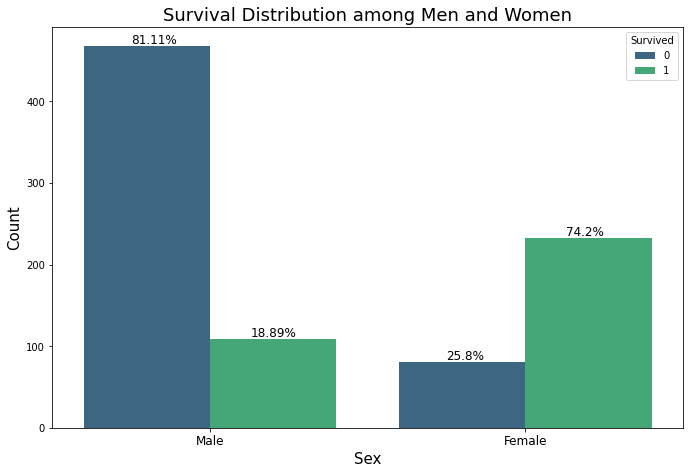

In [ ]:
#Visualising Sex w.r.t Survival:
# plt.text()
# 第一引数 x はテキストのx座標
# 第二引数 y はテキストのy座標
# 第三引数 s はテキストとして表示させる文字列
# 第四引数 fontsize はテキストの文字の大きさ

# comb2.sort_index() で行のインデックスで並び替え
# iloc[891] で index が 891 までのデータを取得
# 取得したデータを y_train と結合


temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
sexSurvival = temp.groupby(by = 'Sex')['Survived'].value_counts()
plt.figure(figsize = (8, 5))
sns.countplot(data = temp, x = 'Sex',  hue = 'Survived', palette = 'viridis')
plt.text(x = -0.25, y = sexSurvival['male'][0] + 3, s = "{}%".format(((sexSurvival['male'][0]/sexSurvival['male'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.13, y = sexSurvival['male'][1] + 3, s = "{}%".format(((sexSurvival['male'][1]/sexSurvival['male'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.25 + 1, y = sexSurvival['female'][0] + 3, s = "{}%".format(((sexSurvival['female'][0]/sexSurvival['female'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.13 + 1, y = sexSurvival['female'][1] + 3, s = "{}%".format(((sexSurvival['female'][1]/sexSurvival['female'].sum())*100).round(2)), fontsize = 12)
plt.title('Survival Distribution among Men and Women', fontsize = 18)
plt.xticks([0, 1], ['Male', 'Female'], fontsize = 12)
plt.xlabel('Sex', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.tight_layout(pad = -5)
plt.show()

男性の死亡率が 81.11% でとても高く、生存率は 18.89% で低い。

女性の死亡率が 25.8% で低く、生存率は 74.2% で高い。

## 乗客のクラスで区別

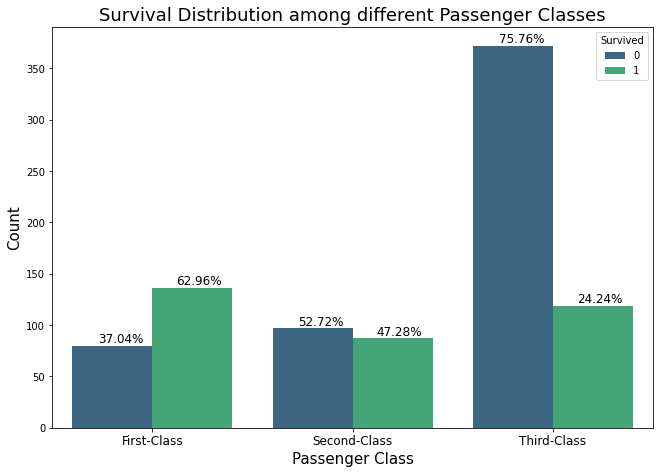

In [ ]:
#Visualising Pclass w.r.t Survival:
pcSurvival = temp.groupby(by = 'Pclass')['Survived'].value_counts()
plt.figure(figsize = (8, 5))
sns.countplot(data = temp, x = 'Pclass',  hue = 'Survived', palette = 'viridis')
plt.text(x = -0.27, y = pcSurvival[1][0] + 3, s = "{}%".format(((pcSurvival[1][0]/pcSurvival[1].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12, y = pcSurvival[1][1] + 3, s = "{}%".format(((pcSurvival[1][1]/pcSurvival[1].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 1, y = pcSurvival[2][0] + 3, s = "{}%".format(((pcSurvival[2][0]/pcSurvival[2].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12 + 1, y = pcSurvival[2][1] + 3, s = "{}%".format(((pcSurvival[2][1]/pcSurvival[2].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 2, y = pcSurvival[3][0] + 3, s = "{}%".format(((pcSurvival[3][0]/pcSurvival[3].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12 + 2, y = pcSurvival[3][1] + 3, s = "{}%".format(((pcSurvival[3][1]/pcSurvival[3].sum())*100).round(2)), fontsize = 12)
plt.title('Survival Distribution among different Passenger Classes', fontsize = 18)
plt.xticks([0, 1, 2], ['First-Class', 'Second-Class', 'Third-Class'], fontsize = 12)
plt.xlabel('Passenger Class', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.tight_layout(pad = -5)
plt.show()

FirstClass の生存率は62.96% と一番高く、 ThirdClass の死亡率が 75.76% で一番高い

FirstClass は生存率が高く、クラスが下がるごとに生存率は下がり、死亡率が上がることがわかる。

## 乗船した都市による分類

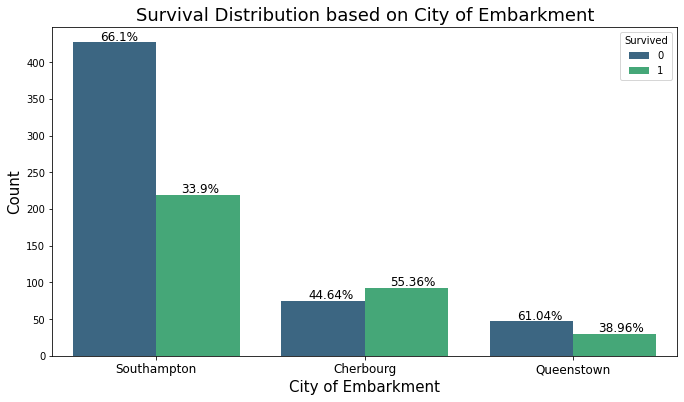

In [ ]:
#Visualising Embarked w.r.t Survival:
ebSurvival = temp.groupby(by = 'Embarked')['Survived'].value_counts()
plt.figure(figsize = (8, 4))
sns.countplot(data = temp, x = 'Embarked',  hue = 'Survived', palette = 'viridis')
plt.text(x = -0.27, y = ebSurvival['S'][0] + 3, s = "{}%".format(((ebSurvival['S'][0]/ebSurvival['S'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12, y = ebSurvival['S'][1] + 3, s = "{}%".format(((ebSurvival['S'][1]/ebSurvival['S'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 1, y = ebSurvival['C'][0] + 3, s = "{}%".format(((ebSurvival['C'][0]/ebSurvival['C'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12 + 1, y = ebSurvival['C'][1] + 3, s = "{}%".format(((ebSurvival['C'][1]/ebSurvival['C'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 2, y = ebSurvival['Q'][0] + 3, s = "{}%".format(((ebSurvival['Q'][0]/ebSurvival['Q'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12 + 2, y = ebSurvival['Q'][1] + 3, s = "{}%".format(((ebSurvival['Q'][1]/ebSurvival['Q'].sum())*100).round(2)), fontsize = 12)
plt.title('Survival Distribution based on City of Embarkment', fontsize = 18)
plt.xticks([0, 1, 2], ['Southampton', 'Cherbourg', 'Queenstown'], fontsize = 12)
plt.xlabel('City of Embarkment', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.tight_layout(pad = -5)
plt.show()

乗船した都市はあまり関係はない？

## Cabin

In [ ]:
#Checking the unique cabin counts:
cabin_values = comb2.Cabin.value_counts()
cabin_values

N/A                1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
C22 C26               4
                   ... 
A7                    1
B19                   1
B86                   1
C110                  1
F E57                 1
Name: Cabin, Length: 187, dtype: int64

In [ ]:
comb2

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,1,"Crosby, Capt. Edward Gifford",Capt.,male,70.0,1,1,WE/P 5735,71.000,B22,S
647,648,1,"Simonius-Blumer, Col. Oberst Alfons",Col.,male,56.0,0,0,13213,35.500,A26,C
694,695,1,"Weir, Col. John",Col.,male,60.0,0,0,113800,26.550,N/A,S
1022,1023,1,"Gracie, Col. Archibald IV",Col.,male,53.0,0,0,113780,28.500,C51,C
1093,1094,1,"Astor, Col. John Jacob",Col.,male,47.0,1,0,PC 17757,227.525,C62 C64,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1250,1251,3,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",Mrs.,female,30.0,1,0,349910,15.550,N/A,S
1256,1257,3,"Sage, Mrs. John (Annie Bullen)",Mrs.,female,35.5,1,9,CA. 2343,69.550,N/A,S
1273,1274,3,"Risien, Mrs. Samuel (Emma)",Mrs.,female,35.5,0,0,364498,14.500,N/A,S
1274,1275,3,"McNamee, Mrs. Neal (Eileen O'Leary)",Mrs.,female,19.0,1,0,376566,16.100,N/A,S


In [ ]:
# Cabin の値があるデータのみを抽出し分析
# isCabinPresent という列を作成し、Cabin のデータが存在するものを抽出
comb2['IsCabinPresent'] = ['Present' if cabin != 'N/A' else 'Not Present' for cabin in comb2.Cabin]
comb2.sample(5)

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabinPresent
1281,1282,1,"Payne, Mr. Vivian Ponsonby",Mr.,male,23.0,0,0,12749,93.5000,B24,S,Present
1217,1218,2,"Becker, Miss. Ruth Elizabeth",Miss.,female,12.0,2,1,230136,39.0000,F4,S,Present
1212,1213,3,"Krekorian, Mr. Neshan",Mr.,male,25.0,0,0,2654,7.2292,F E57,C,Present
234,235,2,"Leyson, Mr. Robert William Norman",Mr.,male,24.0,0,0,C.A. 29566,10.5000,N/A,S,Not Present
245,246,1,"Minahan, Dr. William Edward",Dr.,male,44.0,2,0,19928,90.0000,C78,Q,Present


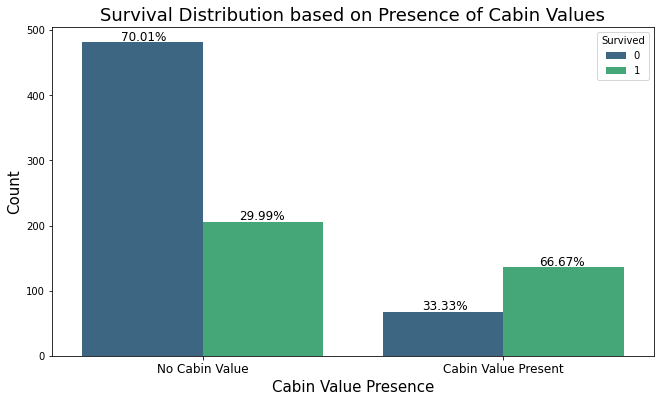

In [ ]:
#Visualising presence of cabin w.r.t Survival
temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
cabSurvival = temp.groupby(by = 'IsCabinPresent')['Survived'].value_counts()
plt.figure(figsize = (8, 4))
sns.countplot(data = temp, x = 'IsCabinPresent',  hue = 'Survived', palette = 'viridis')
plt.text(x = -0.27, y = cabSurvival['Not Present'][0] + 3, s = "{}%".format(((cabSurvival['Not Present'][0]/cabSurvival['Not Present'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12, y = cabSurvival['Not Present'][1] + 3, s = "{}%".format(((cabSurvival['Not Present'][1]/cabSurvival['Not Present'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 1, y = cabSurvival['Present'][0] + 3, s = "{}%".format(((cabSurvival['Present'][0]/cabSurvival['Present'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.12 + 1, y = cabSurvival['Present'][1] + 3, s = "{}%".format(((cabSurvival['Present'][1]/cabSurvival['Present'].sum())*100).round(2)), fontsize = 12)
plt.title('Survival Distribution based on Presence of Cabin Values', fontsize = 18)
plt.xticks([0, 1], ['No Cabin Value', 'Cabin Value Present'], fontsize = 12)
plt.xlabel('Cabin Value Presence', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.tight_layout(pad = -5)
plt.show()

It's clear from the above visualisation that over 70% of the passengers with no cabin value died, whereas only one-third of the passengers with a cabin value present died. Therefore, presence of a cabin value is a distinct predictor of survival and no futher feature engineering is required

## Fare

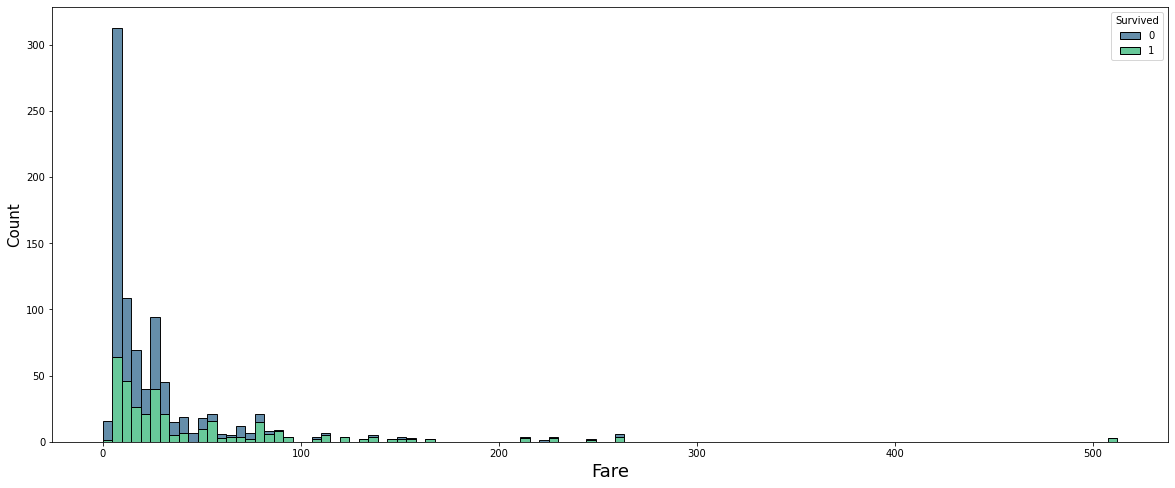

In [ ]:
#Visualising the fare distribution w.r.t survival:

# sns.histplot() よりヒストグラム
# hue はグラフの色分けをするためのメソッドで、今回は Survived の値によって色分けがされている
plt.figure(figsize = (20, 8))
sns.histplot(x = 'Fare', data = temp, hue = 'Survived', multiple = 'stack', palette = 'viridis')
plt.xlabel('Fare', fontsize = 18)
plt.ylabel('Count', fontsize = 15)
plt.show()

In [ ]:
#Calculating the quartiles of 'Fare':

#quantile　の意味は 「分位数」
# 引数に 0.25 を入れた場合は　第一四分位数
# 引数に 0.50 を入れた場合は　第二四分位数
# 引数に 0.75 を入れた場合は　第三四分位数

Q1 = comb2.Fare.quantile(0.25)
Q2 = comb2.Fare.quantile(0.50)
Q3 = comb2.Fare.quantile(0.75)

# 第一四部位数から第三四部位数までをグループ分け
# 最小値の 0 から第一四部位数　　は　"VeryLowFare"
# 第一四部位数 から第二四部位数　　は　"LowFare"
# 第二四部位数 から第三四部位数　　は　"MediumFare"
# 第三四部位数 から最大値 は　"HighFare"

# グループ分けした結果を第十列に FareGroup という列を設けてその分類を記述

print("\n'Very Low Fare' Range:", 0, "-", Q1.round(2))
print("\n'Low Fare' Range:", Q1.round(2), "-", Q2.round(2))
print("\n'Medium Fare' Range:", Q2.round(2), "-", Q3.round(2))
print("\n'High Fare' Range:", Q3, "-", round(max(comb2.Fare), 2), '\n\n')

#Creating fare groups:
comb2.insert(10, 'FareGroup', np.nan)

comb2.loc[(comb2.Fare <= Q1), 'FareGroup'] = 'VeryLowFare'
comb2.loc[(comb2.Fare > Q1) & (comb2.Fare <= Q2), 'FareGroup'] = 'LowFare'
comb2.loc[(comb2.Fare > Q2) & (comb2.Fare <= Q3), 'FareGroup'] = 'MediumFare'
comb2.loc[(comb2.Fare > Q3), 'FareGroup'] = 'HighFare'

comb2.sample(8)


'Very Low Fare' Range: 0 - 7.9

'Low Fare' Range: 7.9 - 14.45

'Medium Fare' Range: 14.45 - 31.28

'High Fare' Range: 31.275 - 512.33 




,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,FareGroup,Cabin,Embarked,IsCabinPresent
536,537,1,"Butt, Major. Archibald Willingham",Major.,male,45.0,0,0,113050,26.5500,MediumFare,B38,S,Present
998,999,3,"Ryan, Mr. Edward",Mr.,male,29.0,0,0,383162,7.7500,VeryLowFare,N/A,Q,Not Present
203,204,3,"Youseff, Mr. Gerious",Mr.,male,45.5,0,0,2628,7.2250,VeryLowFare,N/A,C,Not Present
1019,1020,2,"Bowenur, Mr. Solomon",Mr.,male,42.0,0,0,211535,13.0000,LowFare,N/A,S,Not Present
410,411,3,"Sdycoff, Mr. Todor",Mr.,male,29.0,0,0,349222,7.8958,VeryLowFare,N/A,S,Not Present
871,872,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",Mrs.,female,47.0,1,1,11751,52.5542,HighFare,D35,S,Present
1183,1184,3,"Nasr, Mr. Mustafa",Mr.,male,29.0,0,0,2652,7.2292,VeryLowFare,N/A,C,Not Present
1008,1009,3,"Sandstrom, Miss. Beatrice Irene",Miss.,female,1.0,1,1,PP 9549,16.7000,MediumFare,G6,S,Present


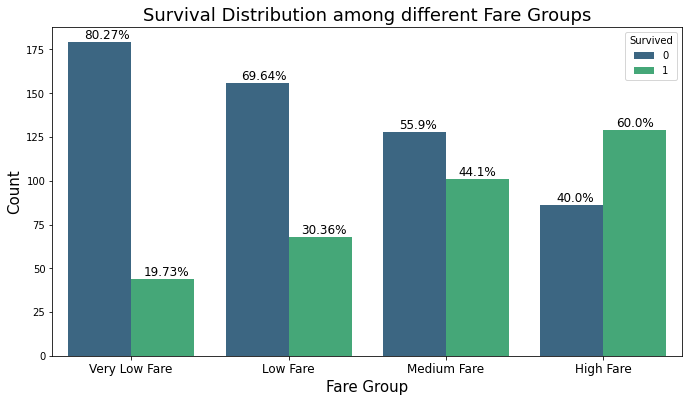

In [ ]:
#Visualising the fare group distribution w.r.t survival:
temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
fgSurvival = temp.groupby(by = 'FareGroup')['Survived'].value_counts()
plt.figure(figsize = (8, 4))
sns.countplot(data = temp, x = 'FareGroup',  hue = 'Survived', order = ['VeryLowFare', 'LowFare', 'MediumFare', 'HighFare'], palette = 'viridis')
plt.text(x = -0.30, y = fgSurvival['VeryLowFare'][0] + 2, s = "{}%".format(((fgSurvival['VeryLowFare'][0]/fgSurvival['VeryLowFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.08, y = fgSurvival['VeryLowFare'][1] + 2, s = "{}%".format(((fgSurvival['VeryLowFare'][1]/fgSurvival['VeryLowFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.30 + 1, y = fgSurvival['LowFare'][0] + 2, s = "{}%".format(((fgSurvival['LowFare'][0]/fgSurvival['LowFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.08 + 1, y = fgSurvival['LowFare'][1] + 2, s = "{}%".format(((fgSurvival['LowFare'][1]/fgSurvival['LowFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.30 + 2, y = fgSurvival['MediumFare'][0] + 2, s = "{}%".format(((fgSurvival['MediumFare'][0]/fgSurvival['MediumFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.08 + 2, y = fgSurvival['MediumFare'][1] + 2, s = "{}%".format(((fgSurvival['MediumFare'][1]/fgSurvival['MediumFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.30 + 3, y = fgSurvival['HighFare'][0] + 2, s = "{}%".format(((fgSurvival['HighFare'][0]/fgSurvival['HighFare'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.08 + 3, y = fgSurvival['HighFare'][1] + 2, s = "{}%".format(((fgSurvival['HighFare'][1]/fgSurvival['HighFare'].sum())*100).round(2)), fontsize = 12)
plt.xlabel('Fare Group', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks([0, 1, 2, 3], ['Very Low Fare', 'Low Fare', 'Medium Fare', 'High Fare'], fontsize = 12)
plt.title('Survival Distribution among different Fare Groups', fontsize = 18)
plt.tight_layout(pad = -5)
plt.show()

料金が高いグループほど生存確率が高いことがわかる。料金が上がるにつれて生存率が上昇し、死亡率が下落していることがわかる。

## Number of Parents or Children and Number of Siblings or Spouses

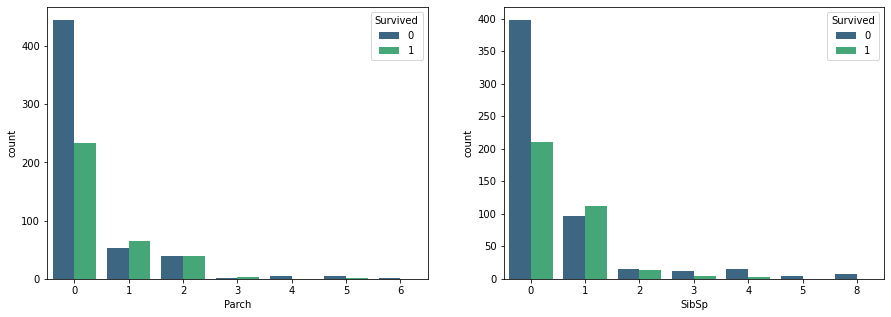

In [ ]:
#Visualising number of parents or children (Parch) and number of siblings or spouses (SibSp) w.r.t Survival:
temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
cols = ['Parch', 'SibSp']
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
for col, subplot in zip(cols, ax.flatten()):
    sns.countplot(data = temp, x = col,  hue = 'Survived', ax = subplot, palette = 'viridis')
    subplot.legend(loc = 'upper right', title = 'Survived')
plt.show()

Let's create another feature called FamilyCount which is the number of family members the passenger has aboard the ship (including themselves).

In [ ]:
#Creating FamilyCount out of Parch and SibSp:
# 家族の人数をまとめた Family Count という列を作成
comb2['FamilyCount'] = 1 + comb2['SibSp'] + comb2['Parch']
comb2.head()

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,Ticket,Fare,FareGroup,Cabin,Embarked,IsCabinPresent,FamilyCount
745,746,1,"Crosby, Capt. Edward Gifford",Capt.,male,70.0,1,1,WE/P 5735,71.000,HighFare,B22,S,Present,3
647,648,1,"Simonius-Blumer, Col. Oberst Alfons",Col.,male,56.0,0,0,13213,35.500,HighFare,A26,C,Present,1
694,695,1,"Weir, Col. John",Col.,male,60.0,0,0,113800,26.550,MediumFare,N/A,S,Not Present,1
1022,1023,1,"Gracie, Col. Archibald IV",Col.,male,53.0,0,0,113780,28.500,MediumFare,C51,C,Present,1
1093,1094,1,"Astor, Col. John Jacob",Col.,male,47.0,1,0,PC 17757,227.525,HighFare,C62 C64,C,Present,2


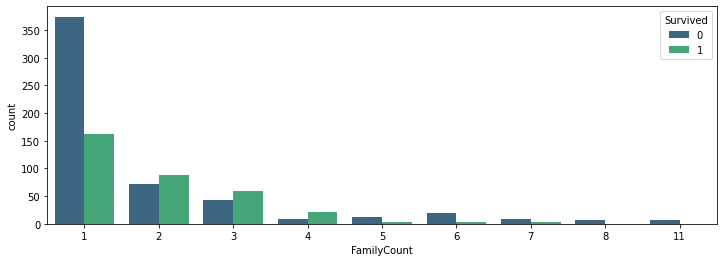

In [ ]:
#Visualising number of family members against survival:

# 家族の人数を x軸にとり、 Survived を hue に指定することで色分け
temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
plt.figure(figsize = (12, 4))
sns.countplot(data = temp, x = 'FamilyCount', hue = 'Survived', palette = 'viridis')
plt.legend(loc = 'upper right', title = 'Survived')
plt.show()

一人の乗客の死亡率が高いことがわかる

In [ ]:
#Creating another feature FamilySize based on groups of family count:
# 乗客をその家族の人数でグループ分け
# 乗客一人の場合は「Alone」
# 乗客1 ~ 4 人の場合は「Medium」
# 乗客４人以上の場合は「Large」
# グループ分けした結果を8列目に代入

comb2.insert(8, 'FamilySize', np.nan)

comb2.loc[(comb2.FamilyCount == 1), 'FamilySize'] = 'Alone'
comb2.loc[(comb2.FamilyCount > 1) & (comb2.FamilyCount <= 4), 'FamilySize'] = 'Medium'
comb2.loc[(comb2.FamilyCount > 4), 'FamilySize'] = 'Large'

comb2.sample(5)

,PassengerId,Pclass,Name,Honorific,Sex,Age,SibSp,Parch,FamilySize,Ticket,Fare,FareGroup,Cabin,Embarked,IsCabinPresent,FamilyCount
1297,1298,2,"Ware, Mr. William Jeffery",Mr.,male,23.0,1,0,Medium,28666,10.5000,LowFare,N/A,S,Not Present,2
328,329,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",Mrs.,female,31.0,1,1,Medium,363291,20.5250,MediumFare,N/A,S,Not Present,3
914,915,1,"Williams, Mr. Richard Norris II",Mr.,male,21.0,0,1,Medium,PC 17597,61.3792,HighFare,N/A,C,Not Present,2
951,952,3,"Dika, Mr. Mirko",Mr.,male,17.0,0,0,Alone,349232,7.8958,VeryLowFare,N/A,S,Not Present,1
10,11,3,"Sandstrom, Miss. Marguerite Rut",Miss.,female,4.0,1,1,Medium,PP 9549,16.7000,MediumFare,G6,S,Present,3


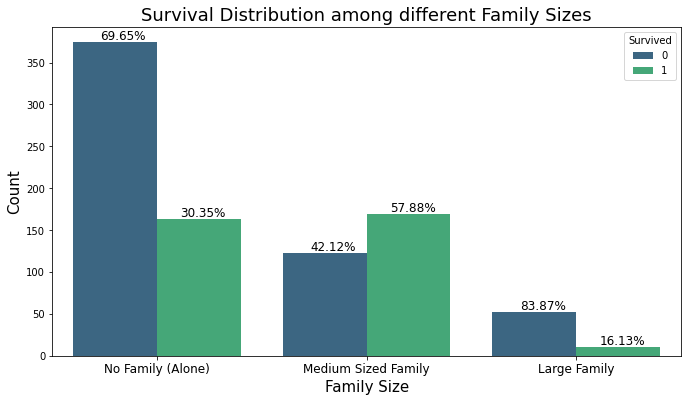

In [ ]:
#Visualising family sizes against survival:
temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
fsSurvival = temp.groupby(by = 'FamilySize')['Survived'].value_counts()
plt.figure(figsize = (8, 4))
sns.countplot(data = temp, x = 'FamilySize', hue = 'Survived', order = ['Alone', 'Medium', 'Large'], palette = 'viridis')
plt.text(x = -0.27, y = fsSurvival['Alone'][0] + 3, s = "{}%".format(((fsSurvival['Alone'][0]/fsSurvival['Alone'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.11, y = fsSurvival['Alone'][1] + 3, s = "{}%".format(((fsSurvival['Alone'][1]/fsSurvival['Alone'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 1, y = fsSurvival['Medium'][0] + 3, s = "{}%".format(((fsSurvival['Medium'][0]/fsSurvival['Medium'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.11 + 1, y = fsSurvival['Medium'][1] + 3, s = "{}%".format(((fsSurvival['Medium'][1]/fsSurvival['Medium'].sum())*100).round(2)), fontsize = 12)
plt.text(x = -0.27 + 2, y = fsSurvival['Large'][0] + 3, s = "{}%".format(((fsSurvival['Large'][0]/fsSurvival['Large'].sum())*100).round(2)), fontsize = 12)
plt.text(x = 0.11 + 2, y = fsSurvival['Large'][1] + 3, s = "{}%".format(((fsSurvival['Large'][1]/fsSurvival['Large'].sum())*100).round(2)), fontsize = 12)
plt.xlabel('Family Size', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks([0, 1, 2], ['No Family (Alone)', 'Medium Sized Family', 'Large Family'], fontsize = 12)
plt.title('Survival Distribution among different Family Sizes', fontsize = 18)
plt.tight_layout(pad = -5)
plt.show()

The relationship between family sizes and survival becomes much more distinct using family size groups (as opposed to using Parch and SibSp). A passenger from a large family has more than 80% chance of dying and passenger with no family aboard has almost 70% chance of dying. Medium sized families have the highest survival rate at almost 58%.
Therefore, family sizes (independently) are distinct predictors of survival and no further feature engineering is required.

棒グラフの数値が小さいためわかりにくくなっているが、最も死亡率が高いのは「Large Family」であり、続いて「Alone」が死亡率が高い。

## Age

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


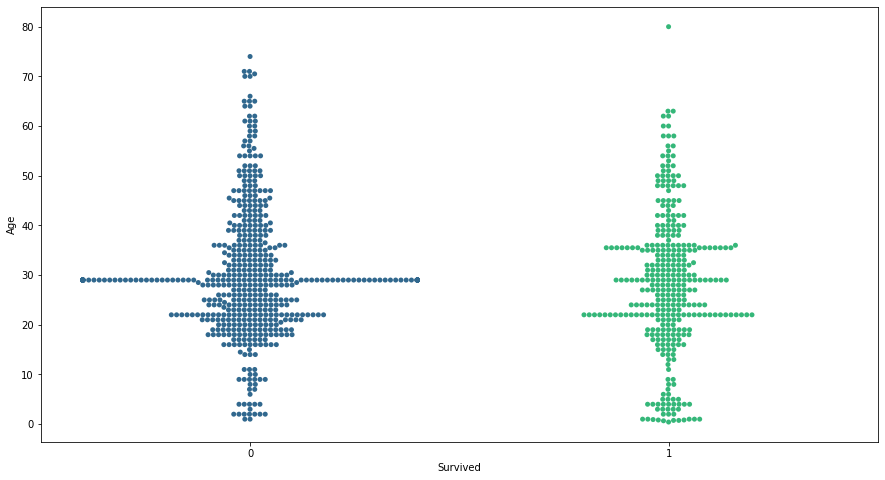

In [ ]:
#Visualising the age distribution w.r.t survival:
temp = pd.concat([comb2.sort_index().iloc[:891], y_train], axis = 1)
plt.figure(figsize = (15,8))
sns.swarmplot(data = temp, x = 'Survived', y = 'Age', palette = 'viridis')
plt.show()

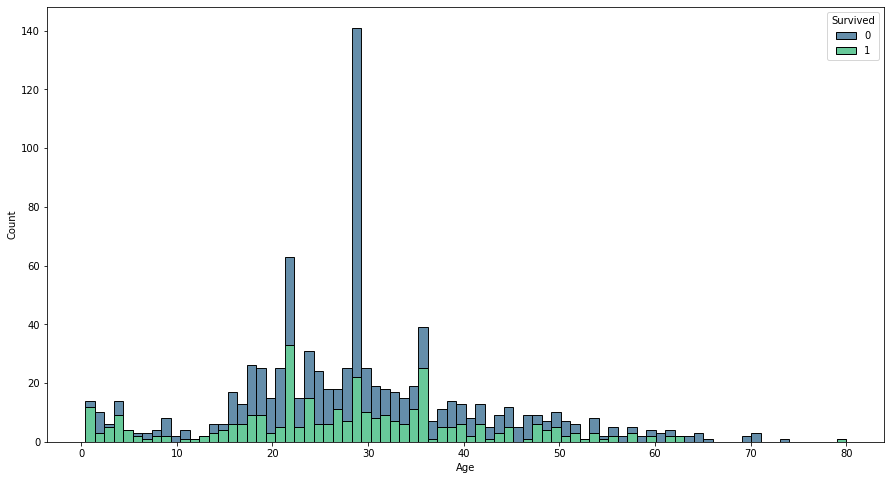

In [ ]:
#Visualising ages w.r.t survival:
# ヒストグラムを作成
# x軸に年齢を取り、hue に Survived を取ることでグラフを色分け
# bins でヒストグラムを 80 ＝ 各年齢ごとに区分け 
plt.figure(figsize = (15, 8))
sns.histplot(data = temp, x = 'Age', hue = 'Survived', multiple = 'stack', bins = 80, palette = 'viridis')
plt.show()

From the above visualisation, the survival rates seem too irregular at different ages and so it's hard to make meaningful age groups out of them.

In [ ]:
# 必要ない列を削除
comb2.drop(['PassengerId', 'Name', 'Ticket', 'Parch', 'SibSp', 'FamilyCount', 'Fare', 'Cabin'], axis  = 1, inplace = True)
comb2.head()

,Pclass,Honorific,Sex,Age,FamilySize,FareGroup,Embarked,IsCabinPresent
745,1,Capt.,male,70.0,Medium,HighFare,S,Present
647,1,Col.,male,56.0,Alone,HighFare,C,Present
694,1,Col.,male,60.0,Alone,MediumFare,S,Not Present
1022,1,Col.,male,53.0,Alone,MediumFare,C,Present
1093,1,Col.,male,47.0,Medium,HighFare,C,Present


In [ ]:
# データフレームの方を確認
comb2.dtypes

Pclass             object
Honorific          object
Sex                object
Age               float64
FamilySize         object
FareGroup          object
Embarked           object
IsCabinPresent     object
dtype: object

In [ ]:
# float 型のデータを取り除き、ダミー変数を取得
# ダミー変数とは、カテゴリ変数を数値化する変数
categoricals = comb2.select_dtypes(exclude = ['int64', 'float64'])
categorical_dummies = pd.get_dummies(categoricals, drop_first = False)
categorical_dummies.head()

,Pclass_1,Pclass_2,Pclass_3,Honorific_Capt.,Honorific_Col.,Honorific_Don.,Honorific_Dona.,Honorific_Dr.,Honorific_Jonkheer.,Honorific_Lady.,...,FamilySize_Medium,FareGroup_HighFare,FareGroup_LowFare,FareGroup_MediumFare,FareGroup_VeryLowFare,Embarked_C,Embarked_Q,Embarked_S,IsCabinPresent_Not Present,IsCabinPresent_Present
745,1,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
647,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
694,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1022,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1093,1,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1


In [ ]:
# 数値を含む行を持ってくる
numericals = comb2.drop(categoricals, axis = 1)
numericals.head()

,Age
745,70.0
647,56.0
694,60.0
1022,53.0
1093,47.0


## Honorific

In [ ]:
# 結婚していない女性を一つのカテゴリにまとめる
# （敬称は「Miss」と「Mlle」があるがそれを「YoungWomen」に統一）
categorical_dummies['YoungWomen'] = categorical_dummies['Honorific_Miss.'] + categorical_dummies['Honorific_Mlle.']

# 結婚している女性を一つのカテゴリにまとめる
# 敬称は「Mrs」と「Mme」と「Ms」があるがそれを「MarriedWomen」に統一
categorical_dummies['MarriedWomen'] = categorical_dummies['Honorific_Mrs.'] + categorical_dummies['Honorific_Mme.'] + categorical_dummies['Honorific_Ms.']

# 珍しい敬称を全て「RareHonorific」一つにまとめる
categorical_dummies['RareHonorific'] = categorical_dummies['Honorific_Capt.'] + categorical_dummies['Honorific_Col.'] 
+ categorical_dummies['Honorific_Don.'] + categorical_dummies['Honorific_Dona.'] + categorical_dummies['Honorific_Dr.'] 
+ categorical_dummies['Honorific_Jonkheer.']  + categorical_dummies['Honorific_Lady.'] + categorical_dummies['Honorific_Major.'] 
+ categorical_dummies['Honorific_Sir.'] + categorical_dummies['Honorific_the Countess.'] + categorical_dummies['Honorific_Rev.']

745     0
647     0
694     0
1022    0
1093    0
       ..
1250    0
1256    0
1273    0
1274    0
979     0
Length: 1309, dtype: uint8

In [ ]:
#Dropping all the features that have since been combined into a new feature:
# 新しく作成した敬称に入った敬称を全て削除
categorical_dummies.drop(['Honorific_Miss.', 'Honorific_Mlle.', 'Honorific_Mrs.', 'Honorific_Mme.', 'Honorific_Ms.', 'Honorific_Dona.', 'Honorific_Lady.', 'Honorific_the Countess.', 'Honorific_Rev.', 'Honorific_Jonkheer.', 'Honorific_Capt.', 'Honorific_Col.', 'Honorific_Major.', 'Honorific_Don.', 'Honorific_Sir.', 'Honorific_Dr.'], 
                         axis = 1, inplace = True)

categorical_dummies.head()

,Pclass_1,Pclass_2,Pclass_3,Honorific_Master.,Honorific_Mr.,Sex_female,Sex_male,FamilySize_Alone,FamilySize_Large,FamilySize_Medium,...,FareGroup_MediumFare,FareGroup_VeryLowFare,Embarked_C,Embarked_Q,Embarked_S,IsCabinPresent_Not Present,IsCabinPresent_Present,YoungWomen,MarriedWomen,RareHonorific
745,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,1
647,1,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1
694,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,1,0,0,0,1
1022,1,0,0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,1,0,0,1
1093,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1


In [ ]:
# 数値とカテゴリ変数の数値を再結合
x = pd.concat([numericals, categorical_dummies], axis = 1)
x.head()

,Age,Pclass_1,Pclass_2,Pclass_3,Honorific_Master.,Honorific_Mr.,Sex_female,Sex_male,FamilySize_Alone,FamilySize_Large,...,FareGroup_MediumFare,FareGroup_VeryLowFare,Embarked_C,Embarked_Q,Embarked_S,IsCabinPresent_Not Present,IsCabinPresent_Present,YoungWomen,MarriedWomen,RareHonorific
745,70.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
647,56.0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,1
694,60.0,1,0,0,0,0,0,1,1,0,...,1,0,0,0,1,1,0,0,0,1
1022,53.0,1,0,0,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,1
1093,47.0,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1


In [ ]:
# これで全てのデータが「float」または「int」に整形
x.dtypes

Age                           float64
Pclass_1                        uint8
Pclass_2                        uint8
Pclass_3                        uint8
Honorific_Master.               uint8
Honorific_Mr.                   uint8
Sex_female                      uint8
Sex_male                        uint8
FamilySize_Alone                uint8
FamilySize_Large                uint8
FamilySize_Medium               uint8
FareGroup_HighFare              uint8
FareGroup_LowFare               uint8
FareGroup_MediumFare            uint8
FareGroup_VeryLowFare           uint8
Embarked_C                      uint8
Embarked_Q                      uint8
Embarked_S                      uint8
IsCabinPresent_Not Present      uint8
IsCabinPresent_Present          uint8
YoungWomen                      uint8
MarriedWomen                    uint8
RareHonorific                   uint8
dtype: object

In [ ]:
# データをインデックス順に並べ替えて、最後の５つのデータを表示
x = x.sort_index(ascending = True)
x.tail()

,Age,Pclass_1,Pclass_2,Pclass_3,Honorific_Master.,Honorific_Mr.,Sex_female,Sex_male,FamilySize_Alone,FamilySize_Large,...,FareGroup_MediumFare,FareGroup_VeryLowFare,Embarked_C,Embarked_Q,Embarked_S,IsCabinPresent_Not Present,IsCabinPresent_Present,YoungWomen,MarriedWomen,RareHonorific
1304,29.0,0,0,1,0,1,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
1305,39.0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1306,38.5,0,0,1,0,1,0,1,1,0,...,0,1,0,0,1,1,0,0,0,0
1307,29.0,0,0,1,0,1,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
1308,4.0,0,0,1,1,0,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0


## Checking Correlation

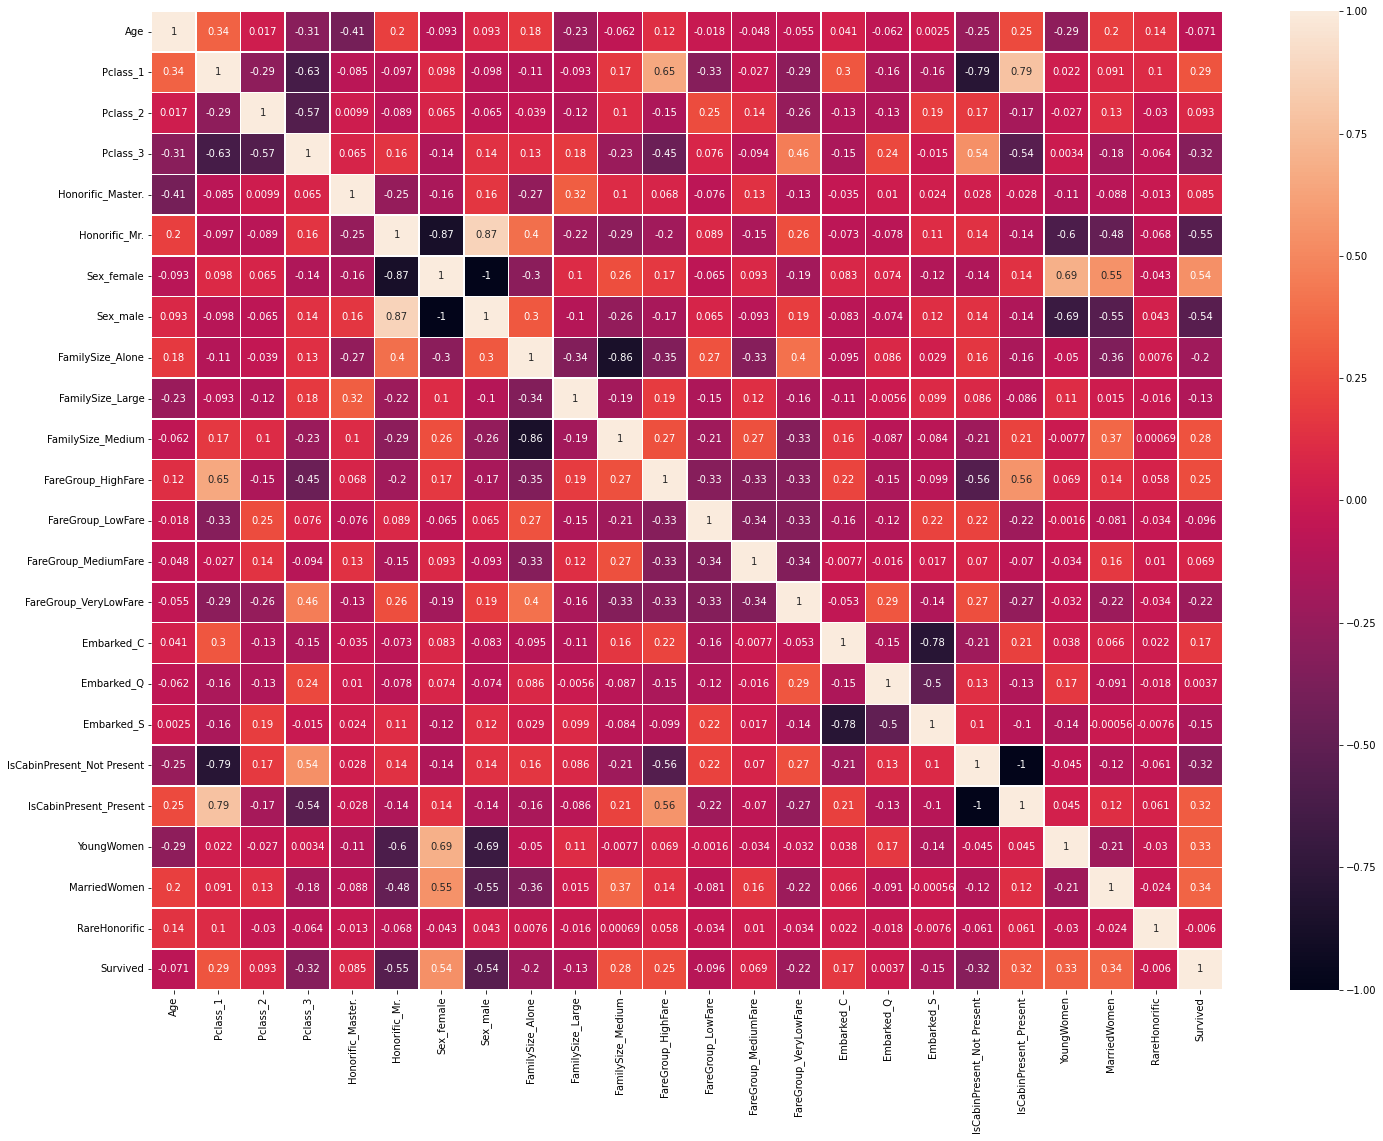

In [ ]:
#Correlation check:
# 相関関係を調べるためにヒートマップを作成
temp = pd.concat([x.iloc[:891], y_train], axis = 1)
corr = temp.corr()
plt.figure(figsize = (24,18))
sns.heatmap(corr, cbar = True, annot = True, linewidths = 0.5)
plt.show()

In [ ]:
# multicollinearity　= 多重共線性 = 互いに関連性の高い説明変数。内相関がある変数
#Removing Sex_male and IsCabinPresent_Not Present features as they're dummy encoded from features that contained only binary classes:
x.drop(['Sex_male', 'IsCabinPresent_Not Present'], axis = 1, inplace = True)

## Scaling the Features

In [ ]:
# StandardScaler = 標準化
#Scaling the independent features:
scaler = StandardScaler()
scaler.fit(x)
X = scaler.fit_transform(x)

## Splitting the Data back into Training and Testing Sets

In [ ]:
#Splitting the transformed data back into training and testing sets:
# データをトレイニングデータとテストデータに分割
X_train = X[:891]
X_test = X[891:]

## Random Forest

In [ ]:
#Creating search parameters for the GridSearchCV
search_parameters = [{'n_estimators': [1000],
                     'criterion': ['gini', 'entropy'],
                     'max_depth': [10, 11, 12],
                     'max_leaf_nodes': [18, 19, 20],
                     'min_samples_leaf': [1],
                     'min_samples_split': [2]}]

ランダムフォレスト（Random forest）は、ディシジョンツリー（Decision tree；決定木）に基づいた機械学習の代表的な手法です。重複を許すランダムサンプリングによって多数のディシジョンツリーを作成し、各ツリーの予測結果の多数決をとることで最終予測値を決定します。
簡単に言えば、「「決定木をたくさん集めて、統合して結果を出力する方法」

決定木の問題

1. 決定木単体ではそれほど高い精度ではない

2. オーバーフィッティング（過学習）を起こしやすい

ランダムフォレストの手順

1. ブートストラップサンプリング（復元抽出）により複数の学習データセットを生成する

2. 学習データセットごとにランダムにK個の特徴量を選択し、ディシジョンツリーをN個作成する

3. N個のディシジョンツリーの結果をアンサンブルにより結合する

ランダムフォレストの主要なパラメータ

・作成するツリーの数

・使用する特徴量の数

作成するツリーの数を多くするとモデルの多様性が高くなるためバリアンスが小さくなりますが、多すぎると計算に時間がかかります。使用する特徴量の数Kは、一般的に特徴量の数Mの平方根（√M）が推奨されています。

特徴 / メリット

・予測精度が高い

・特徴量の重要度が評価できる

・オーバーフィットが起きにくい

・複数のツリーの並列処理が可能

予測精度の向上
ディシジョンツリーは、ツリーが深くなると構造が複雑になりオーバーフィット（Over Fitting；過学習）が起きやすいという問題がありますが、ランダムフォレストはアンサンブル学習によりディシジョンツリーよりも汎化性能（未知のデータに対して正解する能力）に優れ、テストデータへのあてはまりが良くなります。そのため、オーバーフィットが起きにくく、テストデータの予測精度向上が期待できます。

フィールド重要度の評価

ランダムフォレストの特徴量の重要度評価には以下の方法があります。

・不純度の平均減少（MDI；Mean Decrease Impurity）

・精度の平均低下（MDA；Mean Decrease Accuracy）

In [ ]:
#Creating a random forest instance and using GridSearchCV to find the optimal parameters:
# ランダムフォレストはかなりの時間を有する（5分28秒）
rf_cls_CV = RandomForestClassifier(oob_score = True, random_state = 10)

grid = GridSearchCV(estimator = rf_cls_CV, param_grid = search_parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)

rf_grid = grid.fit(X_train, y_train)

print('Best parameters for random forest classifier: ', rf_grid.best_params_, '\n')

Best parameters for random forest classifier:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000} 



Out of bag (OOB) score is a way of validating the Random forest model.

In [ ]:
#Creating a random forest model based on the optimal paramters given by GridSearchCV:
rf_grid_model = RandomForestClassifier(n_estimators = rf_grid.best_params_.get('n_estimators'),
                                       criterion = rf_grid.best_params_.get('criterion'),
                                       max_depth = rf_grid.best_params_.get('max_depth'),
                                       max_leaf_nodes = rf_grid.best_params_.get('max_leaf_nodes'),
                                       min_samples_leaf = rf_grid.best_params_.get('min_samples_leaf'),
                                       min_samples_split = rf_grid.best_params_.get('min_samples_split'),
                                       oob_score = True,
                                       random_state = 10, 
                                       n_jobs = -1)

rf_grid_model = rf_grid_model.fit(X_train, y_train)

In [ ]:
#Making predictions using the optimal random forest:
y_pred_RFGSCV = rf_grid_model.predict(X_test)

In [ ]:
#Final result compilation:
def final_result(model_prediction):
    Passengers = test.PassengerId
    Survived = pd.Series(model_prediction)
    final = pd.concat([Passengers, Survived], axis = 1)
    final.rename(columns = {0:'Survived'}, inplace = True)
    final.to_csv("submission.csv", index = False)

In [ ]:
final_result(y_pred_RFGSCV)